# [LAB-12] 5. 로지스틱 회귀 (이항분류)

- : 종속변수가 범주형 변수일 때의 회귀분석
- 어떤 사건이 발생할 확률을 예측하는 것
- 원래 첨에 제시된 개념: **두개 값(0 or 1) 만 가지는 종속변수에 대한 회쉬분석**
  - 후에 여러 값 갖는 명목형 종속변수에도 적용된거임
  - -> 분류 가능!

## [1] **사용예시:**
1. 금융권: 고객 신용도 평가
   - **고객 신용도가 우량이 될 가능성 A%, 불량이 될 가능성 B%를 예측**
2. 통신사: 
   - 특정 **고객이 2년 약정 종료 후 번호이동으로 타 통신사로 갈 확률 A%, 기기변경으로 남아있을 확률 B% 예측**
3. 의학 분야: 
   - 다양한 원인 파악, 특정 질병에 대해 음성일 확률 A%, 양성일 확률 B%을 예측

## [2] 로지스틱 회귀모형: **S형 곡선**

- 독립변수: 수치형, 범주형 다 가능
- 종속변수: 이분형 범주형 변수 (0 or 1)
  - 0.5보다 ↑: 그 사건이 일어날 / ↓: 안일어날 가능성 크다
  - 결과 그래프가 heatmap 으로 들어감 (기다/아니다)

## [3] 로지스틱의 가정

- **가설의 가정(정규성/등분산성)을 따르지 않음 -> 확인 안해도 됨!**
- but 독립변수에서 확인필요 사항:
  - 다변량 정규분포 따름 유무
  - **다중공선성 (VIF > 10)**

## #01. 준비작업

### 1. 패키지 참조:

In [1]:
# 기본 참조
from hossam import load_data
from pandas import DataFrame, get_dummies
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

# 로지스틱 회귀용 참조
import statsmodels.api as sm

# 로지스틱 사후검정용 참조 (머신러닝 라이브러리 미리 사용함)
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

### 2. 그래프 초기화:

In [2]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 6          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

### 3. 데이터 가져오기:

In [3]:
origin = load_data('graduate')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab12_/graduate.xlsx
[desc] 방사선학 석사과정 대학원생 모집 현황을 조사한 가상의 데이터
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (400, 4)
열 갯수: 4
행 갯수: 400

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   합격여부    400 non-null    int64  
 1   필기점수    400 non-null    int64  
 2   학부성적    400 non-null    float64
 3   병원경력    400 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 12.6+ KB
None


,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,1~5년
1,1,660,3.67,1~5년
2,1,800,4.00,10년 이상
3,1,640,3.19,1년 미만
4,0,520,2.93,1년 미만


## #02. 데이터 전처리

### 1. `병원경력` 종류 확인:

In [4]:
origin['병원경력'].unique()

array(['1~5년', '10년 이상', '1년 미만', '5~10년'], dtype=object)

### 2. 명목형 변수 전처리

#### (1) `데이터 라벨링`: '문자열' 값의 종류별로 '숫자 대응'처리:
   - by map() 함수: `0, 1, 2, ..`등의 숫자체계로 변환

In [5]:
df = origin.copy()
df['병원경력'] = df['병원경력'].map({
    '1년 미만': 0,
    '1~5년': 1,
    '5~10년': 2,
    '10년 이상': 3
})
df['병원경력'].unique()

array([1, 3, 0, 2])

#### (2) 라벨링 후 `category` 타입으로 변환:

   - for: EDA analysis' 통계분석, 머신러닝
   - to prevent: 명목형 변수의 기초통계량 산출
   - by: **`더미변수`** 처리 **(One-Hot Encoding)**
     - **모든 명목형 변수들은 더미변수로 만들어줘야됨!!**
     - **`더미변수(통계분석용)` + `One-Hot Encoding(머신러닝용)`**
       - 범주 당 더미변수가 n개 있다면 더미컬럼을 n-1개 생성함
       - One-Hot Encoding은 더미변수 만큼 더미컬럼을 생성함

In [6]:
df2 = get_dummies(df, columns=['병원경력'], dtype='int', drop_first=True)
df2.head()

,합격여부,필기점수,학부성적,병원경력_1,병원경력_2,병원경력_3
0,0,380,3.61,1,0,0
1,1,660,3.67,1,0,0
2,1,800,4.00,0,0,1
3,1,640,3.19,0,0,0
4,0,520,2.93,0,0,0


## #03. 로지스틱 회귀분석

### 1. 로지스틱회귀분석 수행:

In [7]:
yname = '합격여부'

x = df2.drop(yname, axis=1)
y = df2[yname]
X = sm.add_constant(x)

display(X)

fit = sm.Logit(y, X).fit()
tbl1 = fit.summary()
print(tbl1)

,const,필기점수,학부성적,병원경력_1,병원경력_2,병원경력_3
0,1.0,380,3.61,1,0,0
1,1.0,660,3.67,1,0,0
2,1.0,800,4.00,0,0,1
3,1.0,640,3.19,0,0,0
4,1.0,520,2.93,0,0,0
...,...,...,...,...,...,...
395,1.0,620,4.00,0,1,0
396,1.0,560,3.04,1,0,0
397,1.0,460,2.63,0,1,0
398,1.0,700,3.65,0,1,0


Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   합격여부   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:                 0.08292
Time:                        15:47:36   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 7.578e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5414      1.138     -4.869      0.000      -7.772      -3.311
필기점수           0.0023      0.

> (가설검정의 가정: 정규성, 등분산성은 Pass~!)

## #04. 로지스틱분석의 성능평가 6가지 (이진분류 평가)

(**여기부터 외울거 개 많음**)

### 1. 혼동행렬 (False Positive / False Negative)

##### 이거 시험에 많이나와..

| 구분 | 예시 |
| :---- | :--- |
| TN(True Negative, Negative Negative), 진음성 | 실제 임신 아니고(0), 임신이 아닌 것(0)으로 잘 예측됨 |
| FP(False Positive, Negative Positive), 위양성 | 실제 임신 아닌데(0), 임신(1)으로 예측함. Type1 Error |
| FN(False Negative, Positive Negative), 위음성 | 실제 임신인데(1), 임신이 이난 것(0)으로 예측함. Type2 Error |
| TP(True Positive, Positive Positive), 진양성 | 실제 임신인데(1), 임신인 것(1)으로 잘 예측됨 |

> `머신러닝용 라이브러리로 'TN, FP, FN, TP' 쉽게 구할 수 있다`

### 2. 혼동행렬 구하기

#### (1) 실제 종속변수:

In [8]:
y_true = df2['합격여부'] #: 방법 1 (df 타입)
# y_true = fit.model.endog #: 방법 2 (series 타입)
y_true

0      0
1      1
2      1
3      1
4      0
      ..
395    0
396    0
397    0
398    0
399    0
Name: 합격여부, Length: 400, dtype: int64

#### (2) 로지스틱이 예측한 값:

- `1`일 `확률`을 의미
- 0 또는 1로 맞춰줘야됨

In [9]:
y_pred = fit.predict(X) # df 타입
y_pred

0      0.172627
1      0.292175
2      0.738408
3      0.178385
4      0.118354
         ...   
395    0.488670
396    0.165504
397    0.181062
398    0.463667
399    0.300731
Length: 400, dtype: float64

#### (3) 위 예측결과를 이진값으로 변환하기:

In [10]:
y_pred_fix = y_pred > 0.5
y_pred_fix

0      False
1      False
2       True
3      False
4      False
       ...  
395    False
396    False
397    False
398    False
399    False
Length: 400, dtype: bool

#### (3) 위의 두 값으로 `혼동행렬` 구하기: `confusion_matrix()`

In [11]:
cm = confusion_matrix(y_true, y_pred_fix)
tn, fp, fn, tp = cm.ravel()
display(tn, fp, fn, tp)

np.int64(254)

np.int64(19)

np.int64(97)

np.int64(30)

#### (4) 혼동행렬을 DataFrame으로 변환하기:

In [12]:
cmdf = DataFrame(
    cm, 
    index = ['Actual 0 (TN, FP)', 'Actual 1 (FN, TP)'], 
    columns = ['Predicted(Negative)', 'Predicted(Positive)'])
cmdf

,Predicted(Negative),Predicted(Positive)
"Actual 0 (TN, FP)",254,19
"Actual 1 (FN, TP)",97,30


#### (5) 혼동행렬 데이터프레임 시각화(Heatmap):

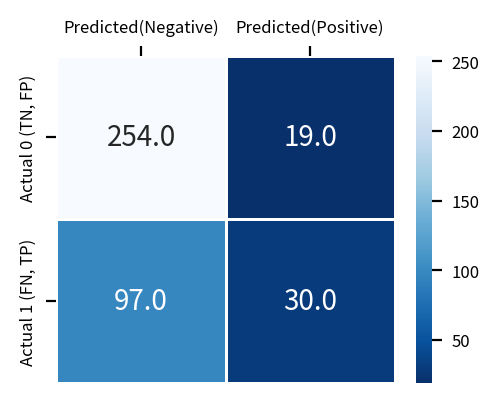

In [13]:
# 1) 그래프 초기화
width_px = 500              # 그래프 가로크기
height_px = 400             # 그래프 세로크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)


# 2) Heatmap 그리기: seaborn 사용
sb.heatmap(data = cmdf, annot=True, fmt='0.1f', 
           linewidth = 0.5, cmap = "Blues_r", 
           annot_kws = {'size': 10})
  # camp: 칼라맵 종류: 'Greys', 'Purples', 'Blues', 'Greens', 
  # 'Oranges', 'Reds' / 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 
  # 'RdPu', 'BuPu' / 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 
  # 'BuGn', 'YlGn' / 'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 
  # 'RdBu', 'RdYlBu' / 'RdYlGn', 'Spectral', 'coolwarm', 
  # 'bwr', 'seismic' / 'berlin', 'managua', 'vanimo'

# 3) 그래프 꾸미기
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()

# 4) 출력
plt.tight_layout()         # 여백 제거
plt.show()                 # 그래프 화면 출력
plt.close()                # 그래프 작업 종료

### 3. 정확도(Accuracy)

- 전체 데이터(FP + FN + TP + TN) 중 제대로 판정한 데이터(TP + TN) 비율
$$Accuracy = \frac{TP~+~TN}{FP~+~FN~+~TP~+~TN}$$

- 마크다운은 LaTex 기호 먹힌다:
  - 앞뒤 달라 두개(`$$수식$$`): 정중앙
  - `\frac{}{}`: 분자/분모 형태로 변환
  - 물결(`~`): 띄어쓰기
  - 참고:
    - https://blog.hossam.kr/posts/%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D-%EA%B3%BC%EC%A0%95%EC%97%90%EC%84%9C-%EC%9E%90%EC%A3%BC-%EC%82%AC%EC%9A%A9%EB%90%98%EB%8A%94-LaTex%EA%B8%B0%ED%98%B8/

#### (1) 직접 구하기 (비추):

In [14]:
(tn + tp) / (tn + tp + fn + fp)

np.float64(0.71)

#### (2) 쉽게 구하기: `accuracy_score()` 함수 이용

In [15]:
acc = accuracy_score(y_true, y_pred_fix)
acc

0.71

### 4. 정밀도 (Precision)

- 양성으로 예측된(tp, fp) 데이터 대비 실제 양성 데이터의 비율:
$$Precision = \frac{TP}{TP~+~FP}$$

In [16]:
#pre = tp / (fp + tp)
pre = precision_score(y_true, y_pred_fix)
pre

0.6122448979591837

### 5. 재현율 (Recall, TPR) 또는 민감도 (Sensitivity)

- 실제 양성(tp, fn)인 데이터들 중 양성으로 '예측'된 데이터 비율:
$$TPR = \frac{TP}{TP~+~FN}$$

In [17]:
#recall = tp / (tp + fn)
recall = recall_score(y_true, y_pred_fix)
recall

0.23622047244094488

### 6. 위양성율, 거짓 양성 비율 (Fallout, FPR, False Positive Rate)

- 실제론 음성(tn, fp)인 관측치 중 양성(fp)으로 예측된 데이터 비율:
$$FPR = \frac{FP}{TN~+~FP}$$

- 함수가 지원 안되므로 직접 계산 해야됨

In [18]:
fpr = fp / (fp + tn)
fpr

np.float64(0.0695970695970696)

### 7. 특이성 (Specificity, TNR, True Negative Rate)
- `1 - 위양성률`.  실제 Negative 값이 정확히 예측되어야 하는 수준을 뜻함
$$TNR = 1~-~FPR = \frac{TN}{TN~+~FP}$$

- 얘도 함수 지원 안됨

In [22]:
tnr = 1 - fpr
tnr

np.float64(0.9304029304029304)

### 8. F1 score

- 정밀도(Precicison)랑 재현율(Recall)의 조화평균 (결합 지표)
- Precision과 Recall이 어느 한 쪽으로 치우치지 않을 때 값이 높음
- > TN은 상관 없.
$$F1 = 2 \times \frac{Precision \times Recall}{Precision~+~Recall} = \frac{2TP}{2TP~+~FP~+~FN}$$

In [20]:
#f1 = 2 * ((pre * recall) / (pre + recall))
f1 = f1_score(y_true, y_pred_fix)
f1

0.3409090909090909

| 지표 | 의미 | 수식 | 기준(분모) | 특징 | When? |
| ---- | --- | ---- |---------- | --- | ----- |
| Accuracy | 전체 중 올바른 비율 | $$Accuracy = \frac{TN~+~TP}{TN~+~TP~+~FP~+~FN}$$ | 전체데이터 | 직관적 but 클래스 불균형에 취약 | 클래스가 **균형**이고 FP,FN의 중요도가 비슷할 때 |
| Precision | Positive로 예측된 것 중 실제 Positive 비율 | $$Precision = \frac{TP}{TP~+~FP}$$ | 예측 Positive | FP에 민감, 보수적 판단 지표 | **FP가 치명적인 경우** (스팸 필터, 추천 시스템) |
| TPR (Recall) | 실제 Positive 중 예측 Positive 비율 | $$TPR = \frac{TP}{TP~+~FN}$$ | 실제 Positive | FN에 민감, 탐지 성능 지표 | **FN이 치명적인 경우** (의료 진단, 이상 탐지) |
| FPR(위양성률) | 실제 Negative 중 잘못 판단한 비율 | $$FPR = \frac{FP}{TN~+~FP}$$ | 실제 Negative | 오경보 정도를 나타냄 | **오경보 비용**을 관리해야 될 때 (보안, 경보 시스템) |
| TNR (Specificity) | 실제 Negative 중 예측 Negative 비율 | $$TNR = 1~-~FPR$$ | 실제 Negative | FPR의 보완 지표 | 정상군 판별이 중요할 때 |
| F1 score | Precision과 Recall의 균형 지표 | $$F1 = \frac{2TP}{2TP~+~FP~+~FN}$$ | Precision & Recall | TN을 고려 안함, 불균형 데이터에 강함 | 클래스 불균형 + **FP,FN 모두 중요한 경우** |

### 10. ROC Curve (ras)

- : 클래스 판별 기준값의 변화에 따른 위양성률(fall-out)과 재현율(recall)의 변화를 시각화 한 것
- > 재현율(recall, fpr)을 x축, 위양성률(fall-out, tpr)을 y축 (hue는 없음)
- 일반적으로 재현율과 위양성율은 `양의 상관관계`가 있음

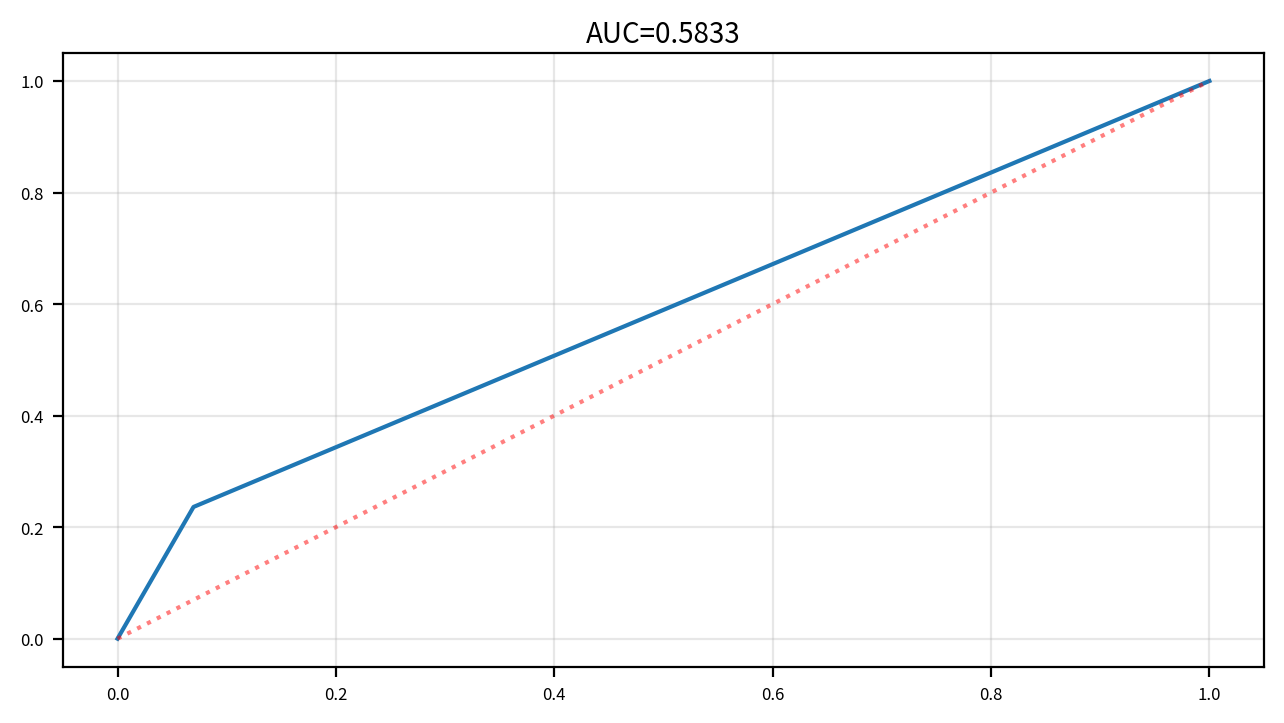

In [24]:
ras = roc_auc_score(y_true, y_pred_fix)

roc_fpr, roc_tpr, thresholds = roc_curve(y_true, y_pred_fix)

# 1) 그래프 초기화 
width_px = 1280             # 그래프 가로 크기
height_px = 720             # 그래프 세로 크기
rows = 1                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) lineplot 그래프 그리기 (w/ seaborn 사용)
sb.lineplot(x=roc_fpr, y=roc_tpr)
sb.lineplot(x = [0, 1], y = [0, 1],
            color = "red", linestyle = ':', 
            alpha=0.5)

# 3) 그래프 꾸미기: 
ax.set_title(f"AUC={ras:.4f}", pad = 4, fontsize = 10)
ax.grid(True, alpha=0.3)                # 배경, 격자 표시/숨김

# 4) 출력
plt.tight_layout()                          # 여백 제거
plt.show()                                  # 그래프 화면 출력
plt.close()                                 # 그래프 작업 종료



- ROC curve: FPR을 0 부터 1 까지 변화시키면서 TPR의 변화값을 구한 것
- 가운데 점직선: ROC 최저값
- ROC curve가 가운데 점선에 
  - 가까울수록: 성능 ↓
  - 멀어질수록: 성능 ↑

### 11. AUC (Area Under Curve)

- ROC 곡선 밑 면적 (1에 가까울 수록 좋은 수치).
  - 가운데 직선에서 멀어지고
  - 왼쪽 상단 모서리 쪽으로 가파르게 곡선 이동할 수록
  - 직사각형 모양에 가까운 곡선 되서
  - 면적 1에 가까워짐.

In [26]:
result_df = DataFrame({
    '설명력(Pseudo-Rsqe)': [fit.prsquared],
    '정확도(Accuracy)': [acc],
    '정밀도(Precision)': [pre],
    '재현율(Recall, TPR)': [recall],
    '위양성률(Fallout, FPR)': [fpr],
    '특이성(Specificity, TNR)': [tnr],
    'RAS': [ras],
    'f1_score': [f1],
})
result_df

,설명력(Pseudo-Rsqe),정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성률(Fallout, FPR)","특이성(Specificity, TNR)",RAS,f1_score
0,0.082922,0.71,0.612245,0.23622,0.069597,0.930403,0.583312,0.340909


## #04. Odds Ratio (오즈비 또는 승산비)

- 수식:
$$\text{Odds Ratio} = \frac{이벤트~발생~확률}{이벤트~미발생~확률} = \frac{p}{1-p}$$
$$\text{Odds Ratio} = \frac{TP/FN}{FP/TN} = \frac{TP\times TN}{FP \times FN}$$

- 관련 함수: `np.exp()`

- 해석법: 
    1. `odds = 1`: 두 그룹 간 발생위험이 동일, 해당 요인과 사건은 관련 없음
    2. `1 < odds`: 노출된 그룹이 비노출 그룹 대비 **1.6배(예시) 더 높은 위험** 가짐
    3. `odds < 1`: 노출된 그룹이 비노출 그룹 대비 **0.5배(예시) 즉 2배 더 낮은 위험** 가짐

- 오즈비 구하는 방법:

### 1. 계수 추출:

In [27]:
coef = fit.params
coef

const    -5.541443
필기점수      0.002264
학부성적      0.804038
병원경력_1    0.211260
병원경력_2    0.876021
병원경력_3    1.551464
dtype: float64

### 2. 오즈값 구하기:

In [29]:
odds_rate = np.exp(coef)
odds_rate_df = DataFrame(odds_rate, columns=['odds_rate'])
odds_rate_df

,odds_rate
const,0.003921
필기점수,1.002267
학부성적,2.234545
병원경력_1,1.235233
병원경력_2,2.401325
병원경력_3,4.718371


10년 이상의 병원경력이 종속변수(합격여부)에 미치는 영향이 제일 크다고 볼 수 있다.
- 병원경력_3: 병원경력 없음 대비 합격 오즈가 약 4.72배 높음

### 3. 오즈비 구하기:

In [31]:
odds_ratio = ( tp * tn ) / ( fp * fn )
odds_ratio

np.float64(4.134563212154097)

> 노출군의 사건 발생 오즈는 비노출군에 비해 약 4.13배 높은 것으로 나타났다

또는

> 설명변수가 1 단위 증가할 때 종속변수가 1이 될 오즈는 약 4.13배 증가한다.

## #05. 가상의 데이터를 통한 예측

In [34]:
myinput = "480, 4.3, 0, 0, 1"
myinput = myinput.split(',')

x_new = DataFrame([{
    '필기점수': int(myinput[0].strip()),
    '학부성적': float(myinput[1].strip()),
    '병원경력_1': int(myinput[2].strip()),
    '병원경력_2' : int(myinput[3].strip()),
    '병원경력_3' : int(myinput[4].strip())
}])

x_new_input = sm.add_constant(x_new, has_constant='add')

myresult = fit.predict(x_new_input)
myresult

0    0.635134
dtype: float64

In [35]:
"당신의 합격 확률은 {0:0.2f}% 입니다.".format(myresult[0]*100)

'당신의 합격 확률은 63.51% 입니다.'

In [36]:
"합격" if myresult[0] > 0.5 else "불합격"

'합격'